YANG Rongfeng, 20644943

Homework for Course *MSBD6000H Natural Language Processing*, BDT, HKUST

The paper is generated by `JupyterLab` and the `.ipynb` is in the `sourceCode` folder. Necessary comments are written with code shown in clear structure so I think the notebook is only source code but also a cool report. Related materials about LDA can be searched in Wikipidia, Google and Baidu, and some open source code in Github was used to demonstrate. The complete procedure is as follows.

There are three section:

1. **Latent Dirichlet Allocation.** Simple knowledge about LDA.
2. **Train a LDA to model News topic.** In this part, I will show how to use nltk and Gensim toolkits to train a LDA model from `20newsgroup`.
3. **Still have something to say.** This is a summary of the whole experiment including some problems that we need to consider.

# Latent Dirichlet Allocation

LDA is used to classify text in a document to a particular topic. It builds a topic per document model and words per topic model, modeled as Dirichlet distributions. 

* Each document is modeled as a multinomial distribution of topics and each topic is modeled as a multinomial distribution of words.
* LDA assumes that the every chunk of text we feed into it will contain words that are somehow related. Therefore choosing the right corpus of data is crucial. 
* It also assumes documents are produced from a mixture of topics. Those topics then generate words based on their probability distribution.

# Train a LDA to model News topic

## Step 1: Load the dataset

The dataset we'll use is the 20newsgroup dataset that is available from sklearn. This dataset has news articles grouped into 20 news categories

In [1]:
from sklearn.datasets import fetch_20newsgroups
newsgroups_train = fetch_20newsgroups(subset='train', shuffle = True)
newsgroups_test = fetch_20newsgroups(subset='test', shuffle = True)

In [2]:
print(list(newsgroups_train.target_names))

['alt.atheism', 'comp.graphics', 'comp.os.ms-windows.misc', 'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware', 'comp.windows.x', 'misc.forsale', 'rec.autos', 'rec.motorcycles', 'rec.sport.baseball', 'rec.sport.hockey', 'sci.crypt', 'sci.electronics', 'sci.med', 'sci.space', 'soc.religion.christian', 'talk.politics.guns', 'talk.politics.mideast', 'talk.politics.misc', 'talk.religion.misc']


### As you can see that there are some distinct themes in the news categories like sports, religion, science, technology, politics etc.

In [3]:
# Lets look at some sample news
newsgroups_train.data[:2]

["From: lerxst@wam.umd.edu (where's my thing)\nSubject: WHAT car is this!?\nNntp-Posting-Host: rac3.wam.umd.edu\nOrganization: University of Maryland, College Park\nLines: 15\n\n I was wondering if anyone out there could enlighten me on this car I saw\nthe other day. It was a 2-door sports car, looked to be from the late 60s/\nearly 70s. It was called a Bricklin. The doors were really small. In addition,\nthe front bumper was separate from the rest of the body. This is \nall I know. If anyone can tellme a model name, engine specs, years\nof production, where this car is made, history, or whatever info you\nhave on this funky looking car, please e-mail.\n\nThanks,\n- IL\n   ---- brought to you by your neighborhood Lerxst ----\n\n\n\n\n",
 "From: guykuo@carson.u.washington.edu (Guy Kuo)\nSubject: SI Clock Poll - Final Call\nSummary: Final call for SI clock reports\nKeywords: SI,acceleration,clock,upgrade\nArticle-I.D.: shelley.1qvfo9INNc3s\nOrganization: University of Washington\nLines: 

In [31]:
print(newsgroups_train.data[1])

From: guykuo@carson.u.washington.edu (Guy Kuo)
Subject: SI Clock Poll - Final Call
Summary: Final call for SI clock reports
Keywords: SI,acceleration,clock,upgrade
Article-I.D.: shelley.1qvfo9INNc3s
Organization: University of Washington
Lines: 11
NNTP-Posting-Host: carson.u.washington.edu

A fair number of brave souls who upgraded their SI clock oscillator have
shared their experiences for this poll. Please send a brief message detailing
your experiences with the procedure. Top speed attained, CPU rated speed,
add on cards and adapters, heat sinks, hour of usage per day, floppy disk
functionality with 800 and 1.4 m floppies are especially requested.

I will be summarizing in the next two days, so please add to the network
knowledge base if you have done the clock upgrade and haven't answered this
poll. Thanks.

Guy Kuo <guykuo@u.washington.edu>



In [5]:
print(newsgroups_train.filenames.shape, newsgroups_train.target.shape)

(11314,) (11314,)


## Step 2: Data Preprocessing ##

We will perform the following steps:

* **Tokenization**: Split the text into sentences and the sentences into words. Lowercase the words and remove punctuation.
* Words that have fewer than 3 characters are removed.
* All **stopwords** are removed.
* Words are **lemmatized** - words in third person are changed to first person and verbs in past and future tenses are changed into present.
* Words are **stemmed** - words are reduced to their root form.

We will use `Gensim LDA Tookit` behind so we load Gensim package at first. And the `nltk` package is also loaded to process natural language.

In [7]:
'''
Loading Gensim and nltk libraries
'''
# pip install gensim
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *
import numpy as np
np.random.seed(400)

In [8]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\yelbee\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\wordnet.zip.


True

### Lemmatizer Example
Before preprocessing our dataset, let's first look at an lemmatizing example. What would be the output if we lemmatized the word 'went':

In [9]:
print(WordNetLemmatizer().lemmatize('went', pos = 'v')) # past tense to present tense

go


### Stemmer Example
Let's also look at a stemming example. Let's throw a number of words at the stemmer and see how it deals with each one:

In [10]:
import pandas as pd
stemmer = SnowballStemmer("english")
original_words = ['caresses', 'flies', 'dies', 'mules', 'denied','died', 'agreed', 'owned', 
           'humbled', 'sized','meeting', 'stating', 'siezing', 'itemization','sensational', 
           'traditional', 'reference', 'colonizer','plotted']
singles = [stemmer.stem(plural) for plural in original_words]

pd.DataFrame(data={'original word':original_words, 'stemmed':singles })

,original word,stemmed
0,caresses,caress
1,flies,fli
2,dies,die
3,mules,mule
4,denied,deni
5,died,die
6,agreed,agre
7,owned,own
8,humbled,humbl
9,sized,size


In [14]:
'''
Write a function to perform the pre processing steps on the entire dataset
'''
def lemmatize_stemming(text):
    return stemmer.stem(WordNetLemmatizer().lemmatize(text, pos='v'))

# Tokenize and lemmatize
def preprocess(text):
    result=[]
    for token in gensim.utils.simple_preprocess(text) :
    # The util of simple preprocess in gensim will remove punctuation and etc.
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 3: 
        # Only keep the Words MORE THAN 3 characters and NOT stopwords.
            result.append(lemmatize_stemming(token)) # Perform our lemmatizae & stemming function       
    return result

In [15]:
'''
Preview a document after preprocessing
'''
document_num = 50
doc_sample = 'This disk has failed many times. I would like to get it replaced.'

print("Original document: ")
words = []
for word in doc_sample.split(' '):
    words.append(word)
print(words)
print("\n\nTokenized and lemmatized document: ")
print(preprocess(doc_sample))

Original document: 
['This', 'disk', 'has', 'failed', 'many', 'times.', 'I', 'would', 'like', 'to', 'get', 'it', 'replaced.']


Tokenized and lemmatized document: 
['disk', 'fail', 'time', 'like', 'replac']


Let's now preprocess all the news headlines we have. To do that, we iterate over the list of documents in our training sample

In [178]:
processed_docs = []

for doc in newsgroups_train.data:
    processed_docs.append(preprocess(doc))

In [17]:
'''
Preview 'processed_docs'
'''
print(processed_docs[:2])

[['lerxst', 'thing', 'subject', 'nntp', 'post', 'host', 'organ', 'univers', 'maryland', 'colleg', 'park', 'line', 'wonder', 'enlighten', 'door', 'sport', 'look', 'late', 'earli', 'call', 'bricklin', 'door', 'small', 'addit', 'bumper', 'separ', 'rest', 'bodi', 'know', 'tellm', 'model', 'engin', 'spec', 'year', 'product', 'histori', 'info', 'funki', 'look', 'mail', 'thank', 'bring', 'neighborhood', 'lerxst'], ['guykuo', 'carson', 'washington', 'subject', 'clock', 'poll', 'final', 'summari', 'final', 'clock', 'report', 'keyword', 'acceler', 'clock', 'upgrad', 'articl', 'shelley', 'qvfo', 'innc', 'organ', 'univers', 'washington', 'line', 'nntp', 'post', 'host', 'carson', 'washington', 'fair', 'number', 'brave', 'soul', 'upgrad', 'clock', 'oscil', 'share', 'experi', 'poll', 'send', 'brief', 'messag', 'detail', 'experi', 'procedur', 'speed', 'attain', 'rat', 'speed', 'card', 'adapt', 'heat', 'sink', 'hour', 'usag', 'floppi', 'disk', 'function', 'floppi', 'especi', 'request', 'summar', 'day',

## Step 3: Bag of words on the dataset

Now let's create a dictionary from 'processed_docs' containing the number of times a word appears in the training set. To do that, let's pass `processed_docs` to [`gensim.corpora.Dictionary()`](https://radimrehurek.com/gensim/corpora/dictionary.html) and call it '`dictionary`'.

In [179]:
'''
Create a dictionary from 'processed_docs' containing the number of times a word appears 
in the training set using gensim.corpora.Dictionary and call it 'dictionary'
'''
dictionary = gensim.corpora.Dictionary(processed_docs)

In [19]:
'''
Checking dictionary created
'''
count = 0
for k, v in dictionary.iteritems():
    print(k, v)
    count += 1
    if count > 10:
        break

0 addit
1 bodi
2 bricklin
3 bring
4 bumper
5 call
6 colleg
7 door
8 earli
9 engin
10 enlighten


**Gensim filter_extremes**

[`filter_extremes(no_below=5, no_above=0.5, keep_n=100000)`](https://radimrehurek.com/gensim/corpora/dictionary.html#gensim.corpora.dictionary.Dictionary.filter_extremes)

Both **very common and very rare** words would be removed. Filter out tokens that appear in

* less than *no_below* documents (absolute number) or 
* more than *no_above* documents (fraction of total corpus size, not absolute number).
* after (1) and (2), keep only the first keep_n most frequent tokens (or keep all if None).

In [20]:
'''
OPTIONAL STEP
Remove very rare and very common words:

- words appearing less than 15 times
- words appearing in more than 10% of all documents
'''
dictionary.filter_extremes(no_below=15, no_above=0.1, keep_n= 100000)

**Gensim doc2bow**

[`doc2bow(document)`](https://radimrehurek.com/gensim/corpora/dictionary.html#gensim.corpora.dictionary.Dictionary.doc2bow)

* Convert document (a list of words) into the bag-of-words format = list of (token_id, token_count) 2-tuples. Each word is assumed to be a tokenized and normalized string (either unicode or utf8-encoded). No further preprocessing is done on the words in document; apply tokenization, stemming etc. before calling this method.

In [180]:
'''
Create the Bag-of-words model for each document i.e for each document we create a dictionary reporting how many
words and how many times those words appear. Save this to 'bow_corpus'
'''
bow_corpus = [dictionary.doc2bow(doc) for doc in processed_docs]

In [22]:
'''
Preview BOW for our sample preprocessed document
'''
document_num = 20
bow_doc_x = bow_corpus[document_num]

for i in range(len(bow_doc_x)):
    print("Word {} (\"{}\") appears {} time.".format(bow_doc_x[i][0], 
                                                     dictionary[bow_doc_x[i][0]], 
                                                     bow_doc_x[i][1]))

Word 18 ("rest") appears 1 time.
Word 166 ("clear") appears 1 time.
Word 336 ("refer") appears 1 time.
Word 350 ("true") appears 1 time.
Word 391 ("technolog") appears 1 time.
Word 437 ("christian") appears 1 time.
Word 453 ("exampl") appears 1 time.
Word 476 ("jew") appears 1 time.
Word 480 ("lead") appears 1 time.
Word 482 ("littl") appears 3 time.
Word 520 ("wors") appears 2 time.
Word 721 ("keith") appears 3 time.
Word 732 ("punish") appears 1 time.
Word 803 ("california") appears 1 time.
Word 859 ("institut") appears 1 time.
Word 917 ("similar") appears 1 time.
Word 990 ("allan") appears 1 time.
Word 991 ("anti") appears 1 time.
Word 992 ("arriv") appears 1 time.
Word 993 ("austria") appears 1 time.
Word 994 ("caltech") appears 2 time.
Word 995 ("distinguish") appears 1 time.
Word 996 ("german") appears 1 time.
Word 997 ("germani") appears 3 time.
Word 998 ("hitler") appears 1 time.
Word 999 ("livesey") appears 2 time.
Word 1000 ("motto") appears 2 time.
Word 1001 ("order") appear

## Step 4: Running LDA using Bag of Words ##

We are going for 10 topics in the document corpus.

**We will be running LDA using all CPU cores to parallelize and speed up model training.**

More details see https://radimrehurek.com/gensim/models/ldamodel.html

Some of the parameters we will be tweaking are:

* **num_topics** is the number of requested latent topics to be extracted from the training corpus.
* **id2word** is a mapping from word ids (integers) to words (strings). It is used to determine the vocabulary size, as well as for debugging and topic printing.
* **workers** is the number of extra processes to use for parallelization. Uses all available cores by default.
* **alpha** and **eta** are hyperparameters that affect sparsity of the document-topic (theta) and topic-word (lambda) distributions. We will let these be the default values for now(default value is `1/num_topics`)
    - Alpha is the per document topic distribution.
        * High alpha: Every document has a mixture of all topics(documents appear similar to each other).
        * Low alpha: Every document has a mixture of very few topics

    - Eta is the per topic word distribution.
        * High eta: Each topic has a mixture of most words(topics appear similar to each other).
        * Low eta: Each topic has a mixture of few words.

* `passes` is the number of training passes through the corpus. For  example, if the training corpus has 50,000 documents, chunksize is  10,000, passes is 2, then online training is done in 10 updates: 
    * `#1 documents 0-9,999 `
    * `#2 documents 10,000-19,999 `
    * `#3 documents 20,000-29,999 `
    * `#4 documents 30,000-39,999 `
    * `#5 documents 40,000-49,999 `
    * `#6 documents 0-9,999 `
    * `#7 documents 10,000-19,999 `
    * `#8 documents 20,000-29,999 `
    * `#9 documents 30,000-39,999 `
    * `#10 documents 40,000-49,999` 

In [182]:
# LDA mono-core -- fallback code in case LdaMulticore throws an error on your machine
# lda_model = gensim.models.LdaModel(bow_corpus, 
#                                    num_topics = 10, 
#                                    id2word = dictionary,                                    
#                                    passes = 50)

# LDA multicore 
'''
Train your lda model using gensim.models.LdaMulticore and save it to 'lda_model'
'''
# TODO
lda_model =  gensim.models.LdaMulticore(bow_corpus, 
                                   num_topics = 8, 
                                   id2word = dictionary,                                    
                                   passes = 10,
                                   workers = 4)

In [24]:
'''
For each topic, we will explore the words occuring in that topic and its relative weight
'''
for idx, topic in lda_model.print_topics(-1):
    print("Topic: {} \nWords: {}".format(idx, topic ))

Topic: 0 
Words: 0.008*"bike" + 0.005*"game" + 0.005*"team" + 0.004*"run" + 0.004*"virginia" + 0.004*"player" + 0.004*"play" + 0.004*"homosexu" + 0.003*"pitch" + 0.003*"motorcycl"
Topic: 1 
Words: 0.009*"govern" + 0.007*"armenian" + 0.006*"israel" + 0.005*"kill" + 0.005*"isra" + 0.004*"american" + 0.004*"turkish" + 0.004*"countri" + 0.004*"weapon" + 0.004*"live"
Topic: 2 
Words: 0.016*"game" + 0.014*"team" + 0.011*"play" + 0.008*"hockey" + 0.008*"player" + 0.005*"season" + 0.005*"canada" + 0.004*"leagu" + 0.004*"score" + 0.004*"toronto"
Topic: 3 
Words: 0.010*"card" + 0.010*"window" + 0.008*"driver" + 0.007*"sale" + 0.006*"price" + 0.005*"speed" + 0.005*"appl" + 0.005*"monitor" + 0.005*"video" + 0.005*"drive"
Topic: 4 
Words: 0.014*"file" + 0.010*"program" + 0.009*"window" + 0.006*"encrypt" + 0.006*"chip" + 0.006*"data" + 0.006*"imag" + 0.006*"avail" + 0.005*"version" + 0.004*"code"
Topic: 5 
Words: 0.012*"space" + 0.009*"nasa" + 0.006*"scienc" + 0.005*"orbit" + 0.004*"research" + 0.00

### Classification of the topics

The output from the model is a 8 topics each categorized by a series of words. The LDA model doesn't give a topic name and it is for us humans to interpret them. The following example shows the possible explanation to the outputs.


* Topic 3: **Possibly Graphics Cards.** Words: "drive" , "sale" , "driver" , *"wire" , "card" , "graphic" , "price" , "appl" ,"softwar", "monitor"
* Topic 5: **Possibly Space.** Words: "space","nasa" , "drive" , "scsi" , "orbit" , "launch" ,"data" ,"control" , "earth" ,"moon"
* Topic 2: **Possibly Sports.** Words: "game" , "team" , "play" , "player" , "hockey" , season" , "pitt" , "score" , "leagu" , "pittsburgh"
* Topic 1: **Possibly Politics.** Words: "armenian" , "public" , "govern" , "turkish", "columbia" , "nation", "presid" , "turk" , "american", "group"
* Topic 5: **Possibly Religion.** Words: "kill" , "bike", "live" , "leav" , "weapon" , "happen" , *"gun", "crime" , "car" , "hand"


## Step 5: Tune the parameters

Although we can tune many parameters --- `num_topics`, `workers`, `passes`, `id2word`, `alpha` and `eta`, we focus on the topic number tuning. An the  **perplexity** is used to evaluate the performace of LDA models.

In the Blei's $paper^{[1]}$, he proposed the *perplexity*

$$
perplexity(D_{test}) = exp \left \{-\frac{\sum_{d=1}^M {\rm log}p(w_d)}{\sum_{d=1}^{M} N_d} \right\}
$$

where $D_{test}$ is the testing set in corpus with $M$ documents, $N_d$ is the number of characters in the d-th document, $w_d$ is the word in the d-th document, $p(w_d)$ is the probalility of the word $w_d$.

[1] Blei D M, Ng A Y, Jordan M I. Latent Dirichlet Allocation[J]. Journal of Machine Learning Research, 2003, 3: 993-1022.

In [183]:
processed_test_docs = []

# Prprocess the testing data
print("Preprocess the testing data")
for doc in newsgroups_test.data:
    processed_test_docs.append(preprocess(doc))
    
dictionary_test = gensim.corpora.Dictionary(processed_test_docs)
dictionary_test.filter_extremes(no_below=15, no_above=0.1, keep_n= 100000)
bow_corpus_test = [dictionary_test.doc2bow(doc) for doc in processed_test_docs]

Preprocess the testing data


In [88]:
num_topics = []
perplexity = []

# Tune the topics number from 5 to 100, with step 5, computing perplexity at each step
for num in range(5, 90, 5):
    print("training: num_topics = " + str(num))
    model_cache = gensim.models.LdaMulticore(bow_corpus, 
                                             num_topics = num, 
                                             id2word = dictionary,                                    
                                             passes = 10,
                                             workers = 2)
    num_topics.append(num)
    # compute the log_perlexity in testing data and save in the array
    perp = model_cache.log_perplexity(bow_corpus_test)
    print(perp)
    perplexity.append(perp)

print(num_topics)
print(perplexity)

training: num_topics = 5
-8.985187677239832
training: num_topics = 10
-9.091199636437919
training: num_topics = 15
-9.180274354467116
training: num_topics = 20
-9.25485612620935
training: num_topics = 25
-9.313999230245098
training: num_topics = 30
-9.36807569492845
training: num_topics = 35
-9.418874161086626
training: num_topics = 40
-9.462085281599574
training: num_topics = 45
-9.505121670884284
training: num_topics = 50
-9.544827363520362
training: num_topics = 55
-9.575815132523568
training: num_topics = 60
-9.62388263184333
training: num_topics = 65
-9.653346168264333
training: num_topics = 70
-9.694311583597909
training: num_topics = 75
-9.721041004493559
training: num_topics = 80
-9.743915555232537
training: num_topics = 85
-9.768902380011026
[5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85]
[-8.985187677239832, -9.091199636437919, -9.180274354467116, -9.25485612620935, -9.313999230245098, -9.36807569492845, -9.418874161086626, -9.462085281599574, -9.505121670

The `log_perplexity` method can be found in [gensim official document](https://radimrehurek.com/gensim/models/ldamodel.html).


* log_perplexity(chunk, total_docs=None)
    - Calculate and return per-word likelihood bound, using a chunk of documents as evaluation corpus.
    - Also output the calculated statistics, including the perplexity=2^(-bound), to log at INFO level.


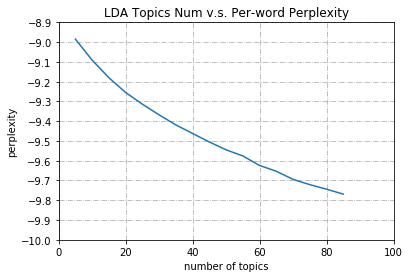

In [127]:
import math
import matplotlib.pyplot as plt
from matplotlib.pyplot import MultipleLocator

plt.xlabel('number of topics')
plt.ylabel('perplexity')
plt.title('LDA Topics Num v.s. Per-word Perplexity')

ax=plt.gca()
y_major_locator=MultipleLocator(0.1)
ax.yaxis.set_major_locator(y_major_locator)

plt.xlim(0, 100)
plt.ylim(-10.0, -8.9)

plt.grid(True, linestyle='-.')


plt.plot(num_topics, perplexity)
plt.show()

According to the graph, we could choose the **k = 20** as our optimal number of topics which is exactly the ground truth ( i.e. 20 newsgroup dataset ).

## Step 6: Testing model on unseen document ##

In [128]:
num = 100
unseen_document = newsgroups_test.data[num]
print(unseen_document)

Subject: help
From: C..Doelle@p26.f3333.n106.z1.fidonet.org (C. Doelle)
Lines: 13

Hello All!

    It is my understanding that all True-Type fonts in Windows are loaded in
prior to starting Windows - this makes getting into Windows quite slow if you
have hundreds of them as I do.  First off, am I correct in this thinking -
secondly, if that is the case - can you get Windows to ignore them on boot and
maybe make something like a PIF file to load them only when you enter the
applications that need fonts?  Any ideas?


Chris

 * Origin: chris.doelle.@f3333.n106.z1.fidonet.org (1:106/3333.26)



In [129]:
# Data preprocessing step for the unseen document
bow_vector = dictionary.doc2bow(preprocess(unseen_document))

for index, score in sorted(lda_model[bow_vector], key=lambda tup: -1*tup[1]):
    print("Score: {}\t Topic: {}".format(score, lda_model.print_topic(index, 5)))

Score: 0.6119418740272522	 Topic: 0.010*"card" + 0.010*"window" + 0.008*"driver" + 0.007*"sale" + 0.006*"price"
Score: 0.3638182580471039	 Topic: 0.014*"file" + 0.010*"program" + 0.009*"window" + 0.006*"encrypt" + 0.006*"chip"


In [130]:
print(newsgroups_test.target[num])

2


The model correctly classifies the unseen document with 'x'% probability to the X category.

# Still have something to say

After doing the whole pipline, I still have questions about the function `log_perplexity()` provided by Gensim. Its return value is negative which is actually per-word likelihood bound not perplexity. When calculating $perplexity = 2^{(-bound)}$, I found the perplexity becomes bigger as the topics number increases, which is contradictory to our intuition (the perplexity should be decrease). Hence I searched the discussion about the issue on GoogleGroup

* [https://groups.google.com/forum/#!searchin/gensim/topic$20coherence|sort:relevance/gensim/krs1Uytq5bY/ePZXIKfwGwAJ](https://groups.google.com/forum/#!searchin/gensim/topic\$20coherence|sort:relevance/gensim/krs1Uytq5bY/ePZXIKfwGwAJ)
* [https://groups.google.com/forum/#!searchin/gensim/perplexity%7Csort:relevance/gensim/TpuYRxhyIOc/98kCvxcpDLcJ](https://groups.google.com/forum/#!searchin/gensim/perplexity%7Csort:relevance/gensim/TpuYRxhyIOc/98kCvxcpDLcJ)
* [https://groups.google.com/forum/#!topic/gensim/iK692kdShi4](https://groups.google.com/forum/#!topic/gensim/iK692kdShi4)

![Lev Confirm](./lev-confirm.png)

Lev. K confirmed that *the perplexity is not normalised across num_topics so it is not comparable.* In fact, Someone reported this NONE normalization problem in 2013, and at that time, Radim, the developer of Gensim said he would patch this bug. However after three years, the problem still existed in 2016 and doesn't be patched when I use it today! Haha...

![Rad will patch](./rad-will-patch.png)

![No patch](./no-patch.png)

Lev. K also posted a blog to give some help. In this [blog post](http://www.google.com/url?q=http%3A%2F%2Fwww.kdnuggets.com%2F2016%2F07%2Famericas-next-topic-model.html&sa=D&sntz=1&usg=AFQjCNHEuAMigBtDis4vtrLOTAOGnFWCng), it shows another method to evaluate LDA models using `Coherence` to choose the best topic model ( Seen in [jupyter notebook demeonstration](https://nbviewer.jupyter.org/github/dsquareindia/gensim/blob/a4b2629c0fdb0a7932db24dfcf06699c928d112f/docs/notebooks/topic_coherence_tutorial.ipynb) ). This maybe provides us another way of thought to improve the evaluation process. I have to confess that I did not well in tuning the parameter in step 6 just by using the defective `log_perplexity()` function.